<a href="https://colab.research.google.com/github/LawZhou/Cartpole-v0/blob/main/Cartpole_v0-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [16]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [17]:
import gym
import numpy as np
from tqdm import tqdm

In [18]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [20]:
class CartpoleAgent():
    def __init__(self, env, num_episodes, bins=(10, 10, 20, 20), min_lr=0.1, epsilon=0.2, lr=1.0,
                 discount_factor=1.0, lr_decay=0.25):
        '''
        Information about Cartpole-v0 env
        check https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py for more details.
        Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
        Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

        env: the environment.
        num_episodes: number of episodes to train.
        bins: a tuple specifies the number of bins for each observation.
        min_lr: the minimum learning rate.
        epsilon: the probability of exploration.
        lr: learning rate.
        discount_factor: discount factor.
        lr_decay: the rate of learning rate decay.
        render: to toggle render during training.
        '''
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.lr_decay = lr_decay
        self.lr = lr
        self.env = env

        # Discretize the continuous space using bins.
        self.bins = bins
        self.position_bins = np.linspace(self.env.observation_space.low[0],
                                         self.env.observation_space.high[0], num=self.bins[0])
        self.pos_velocity_bins = np.linspace(-4, 4, num=self.bins[1])
        self.angle_bins = np.linspace(self.env.observation_space.low[2],
                                      self.env.observation_space.high[2], num=self.bins[2])
        self.angle_velopcity_bins = np.linspace(-4, 4, num=self.bins[3])

        self.Q = np.zeros(self.bins + (self.env.action_space.n,))  # Q-table

    def train(self, verbose=True):
        '''
        Train the model for self.num_episodes episodes.
        '''
        steps_recorder = []
        ite = tqdm(range(self.num_episodes), position=0) if verbose else range(self.num_episodes)
        for ep in ite:
            state = self.env.reset()
            state = self.discretize_state(state)
            self.lr = self.get_learning_rate()
            done = False
            steps_counter = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)
                self.update_Q(state, action, reward, next_state)
                state = next_state
                steps_counter += 1
            steps_recorder.append(steps_counter)
        return steps_recorder

    def update_Q(self, state, action, reward, next_state):
        '''
        Update the Q table by equation:
        Q(S, A) <- Q(S, A) + alpha*[reward + discount_factor*max_a(Q(S', a) - Q(S, A))]
        '''
        self.Q[state][action] += self.lr * (
                reward + self.discount_factor * np.max(self.Q[next_state]) - self.Q[state][action])

    def discretize_state(self, obs):
        '''
        Discretize the continuous state using bins.
        '''
        discrete_pos = np.digitize(obs[0], bins=self.position_bins)-1  # -1 turns bin into index
        discrete_pos_vel = np.digitize(obs[1], bins=self.pos_velocity_bins)-1
        discrete_angle = np.digitize(obs[2], bins=self.angle_bins)-1
        discrete_angle_vel = np.digitize(obs[3], bins=self.angle_velopcity_bins)-1
        discrete_state = np.array([discrete_pos, discrete_pos_vel, discrete_angle, discrete_angle_vel]).astype(np.int)
        return tuple(discrete_state)

    def choose_action(self, state, greedy=False):
        '''
        Choose action by following epsilon-greedy policy.
        '''
        if not greedy:
            # For training
            if np.random.random() < self.epsilon:  # Exploration
                return self.env.action_space.sample()
            else:
                return np.argmax(self.Q[state]) # Exploitation
        else:
            # For evaluation
            return np.argmax(self.Q[state])


    def get_learning_rate(self):
        '''
        Decay the learning rate to slow down learning in the later episodes.
        '''
        return max(self.min_lr, self.lr - self.lr * self.lr_decay)


    def run(self):
        '''
        Run an episode using the updated Q table.
        '''
        state = self.env.reset()
        for ep in range(50000):
            state = self.discretize_state(state)
            action = self.choose_action(state, greedy=True)
            obs, reward, done, info = self.env.step(action)
            if done:
                break
            state = obs
        return ep
    
    def run_with_render(self):
      state = self.discretize_state(self.env.reset())
      for i in range(50000):
        state = self.discretize_state(state)
        action = self.choose_action(state, greedy=True)
        obs, reward, done, info = self.env.step(action)
        show_state(self.env, step=i)
        if done:
          break
        state = obs
      self.env.close()
      print("Steps that were run:",i)

def run_episodes(agent, verbose=False, play_eps=2000):
    '''
    Run {play_eps} episodes and compute average returns.
    return True if the problem is solved.
    '''
    steps_recorder = []
    num_solved_ep = 0
    solved = False
    for _ in range(play_eps):
        returns = agent.run()
        num_solved_ep += 1 if returns >= 195 else 0
        if num_solved_ep >= 100: solved = True
        steps_recorder.append(returns)
    steps_recorder = np.array(steps_recorder)
    avg_rtn = np.mean(steps_recorder)
    if verbose:
        print(f'Finish with mean steps: {avg_rtn} in {play_eps} episodes')
        print(f'{np.count_nonzero(steps_recorder >= 195)} episodes last more than 195 steps.')
        if solved:
          print('Problem solved.')
    return solved, avg_rtn


def show_state(env, step=0, info=""):
    '''
    Render the environment.
    Reference: https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
    '''
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

def visualize(steps):
    num_episodes = len(steps)
    plt.bar(range(num_episodes), steps, width=0.5)
    plt.title("Number of steps VS episodes in training")
    plt.ylabel('Number of steps')
    plt.xlabel('Episodes')
    plt.show()


# Hyperparameter tuned model

In [ ]:
import itertools as it

## Hyperparameter Tuning
params = {
    'epsilon': [0.05, 0.1, 0.2, 0.5],
    'lr': [0.7, 0.8, 0.9, 1],
    'discount_factor': [0.7, 0.8, 0.9, 1.0]
}

def hyperparameter_tuning(agent_func, train_eps = 1000, play_eps = 100, params = params):
    env = gym.make('CartPole-v0')
    combinations = it.product(*(params[param] for param in params))
    
    [best_agent, best_parameters, best_avg_rtn] = [None] * 3
    
    for combination in tqdm(list(combinations), position=0):
        kwarg = {list(params.keys())[i]: combination[i] for i in range(len(params.keys()))}
        agent = agent_func(env, num_episodes = train_eps, **kwarg)
        step_recorder = agent.train(verbose=False)
        solved, avg_rtn = run_episodes(agent, play_eps = play_eps)
        if not best_avg_rtn or avg_rtn > best_avg_rtn:
            best_agent, best_parameters, best_avg_rtn = agent, kwarg, avg_rtn
    return best_agent, best_parameters, best_avg_rtn
            
best_agent, best_parameters, best_avg_rtn = hyperparameter_tuning(CartpoleAgent)

print(f'best_parameters: {best_parameters}')
print(f'best_avg_rtn: {best_avg_rtn}')

100%|██████████| 64/64 [03:28<00:00,  3.26s/it]

best_parameters: {'epsilon': 0.5, 'lr': 0.7, 'discount_factor': 0.9}
best_avg_rtn: 195.85


In [ ]:
env = gym.make('CartPole-v0')

print('train using Q learning:')
env.reset()
agent = CartpoleAgent(env, num_episodes=5000, **best_parameters)
step_recorder = agent.train()
solved, avg_rtn = run_episodes(agent)

  1%|          | 40/5000 [00:00<00:12, 391.39it/s]

train using Q learning:


100%|██████████| 5000/5000 [00:39<00:00, 128.13it/s]


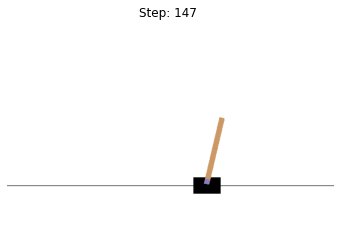

Steps that were run: 147


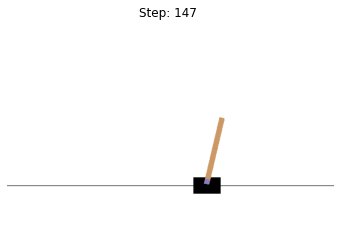

In [ ]:
agent.run_with_render()

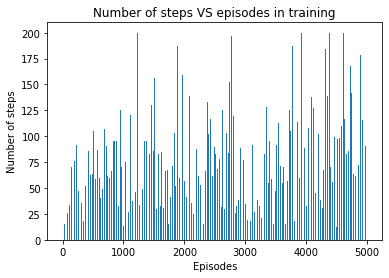

In [ ]:
visualize(step_recorder)

# Hyperparameter untuned model

In [25]:
env = gym.make('CartPole-v0')

print('train using Q learning:')
env.reset()
agent = CartpoleAgent(env, num_episodes=5000)
step_recorder = agent.train()
solved, avg_rtn = run_episodes(agent, verbose=True)

  2%|▏         | 119/5000 [00:00<00:04, 1187.28it/s]

train using Q learning:


100%|██████████| 5000/5000 [00:53<00:00, 93.28it/s]


Finish with mean steps: 191.521 in 2000 episodes
1649 episodes last more than 195 steps.
Problem solved.


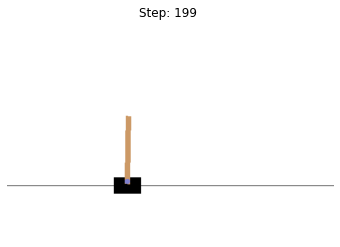

Steps that were run: 199


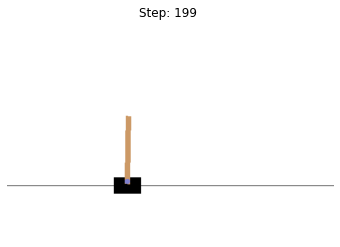

In [28]:
agent.run_with_render()

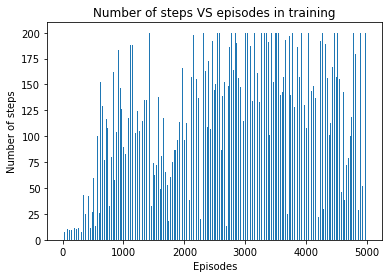

In [27]:
visualize(step_recorder)